## Notebook Intentions

The purpose of this notebook is to report on the concentration of expenditure among the population over time. This notebook closely follows the methodology described in [STATISTICAL BRIEF #533:
Concentration of Healthcare Expenditures and Selected Characteristics of High Spenders, U.S. Civilian Noninstitutionalized Population, 2018](https://www.meps.ahrq.gov/data_files/publications/st533/stat533.shtml), yet expands the research to the past decade.

## Structure

For each year we identify the total spending thresholds that intertect the population at various percentiles. For this notebook we will be evaluating all percentiles divisible by 10 as well as the 75th, 95th and 99th percentile. Once these thresholds have been identified we can calculate the percentage of annual spending and total annual spending attributed to members of each percentile.

Using these values we can generate a concentration curve. The cumulative percentage of the population is represented along the X-axis, and the total expenditures is represented on the Y-axis. At the point where the x-axis is equal to 0.7 and the y-axis is equal to 214 this indicates the the bottom 70% of the population has a total of 214 billion dollars in expenditures. The label at each point represents the percentage of the sub-population's expenditures out of the full population's expenditures. The label at the coordinates (0.7, 214) of 10.8% indicates that the bottom 70% of the population accounts for 10.8% of overall spending. Conversely the top 30% accounts for 89.2% of overall spending. 

Rather than generate a concentration curve for each year we only display the curve for 2018. To allow for comparisons across years we display the curves as a bar graph with each percentile over 0.5 given it own bar. This reduces noise while only removing ~4% of total expenditures. We generate a graph that demonstrates the percentage of annual spending and a graph that demonstrates total annual spending attributed to members of each percentile.


## Findings

Expenditure concentration is highly skewed to the top 20, 5 and 1st percentiles for all years, accounting for 80%, 50% and 20% of all expenditures respectively. These proportions have remained relatively stable from 2008-2018 with no years or percentiles being statistically differentiable than the others in their groups. While the proportions have remained stable the total expenditures has increased consistently over the decade. With percentiles 0.5 through 0.9 increasing enough to be statistically significant.

In [1]:
import os
from os.path import expanduser

import sys
sys.path.append(os.path.join(expanduser("~"), "meps", "meps_dev"))

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "meps_db.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import django
django.setup();

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from textwrap import wrap

from meps_db.components.reference import DATA_FILES_YEARS
from meps_db.analysis.expenses import ExpensesAnalyzer

In [2]:
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12, "axes.ticksize": 12}) 

In [3]:
# Initializer analyzer
expenses_analyzer = ExpensesAnalyzer(years = DATA_FILES_YEARS[:11])

In [4]:
# calculate quantiles for decade
quantile_expenses = expenses_analyzer.calculate_quantile_expenses()
quantile_expenses_df = pd.DataFrame(quantile_expenses)

## Concentration Curve of Healthcare Expenditures 2018

in 2018, spending on healthcare accounted for 17.7 percent of the United States gross domestic product, yet the majority of this spending was concentrated in a small percentage of the population. MEPS data show that about 13 percent of the U.S. civilian noninstitutionalized population had no personal healthcare expenditures in 2018. On the other hand, only 5 percent of the population accounted for nearly half of healthcare spending. This spending includes all sources of payments for medical care, including private insurance payments, Medicare, Medicaid, out-of-pocket spending, and other sources.


Here we describe the overall concentration of healthcare expenditures across the U.S. civilian noninstitutionalized population in 2018.

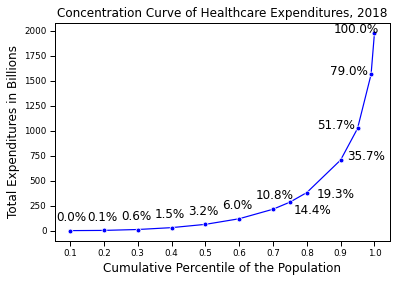

In [5]:
quans_2018 = quantile_expenses_df.loc[(quantile_expenses_df["year"]==2018)]
ax = sns.lineplot(
    data=quans_2018, 
    x="quantile", 
    y="total_exp", 
    marker= "o", 
    color="b"
)
ax.set_title("Concentration Curve of Healthcare Expenditures, 2018")
ax.set(xticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set(xlabel="Cumulative Percentile of the Population")
ax.set(ylabel="Total Expenditures in Billions")

# need to hardcode due to exponential curve
for x, y, label in zip(
    quans_2018["quantile"], quans_2018["total_exp"], quans_2018["cum_pct_exp"]
):
    if x == 0.1:
        x_fudge, y_fudge = -0.04, 100
    elif x <= 0.7:
        x_fudge, y_fudge = -0.05, 100
    elif x == 0.7:
        x_fudge, y_fudge = -0.05, -100
    elif x == 0.75:
        x_fudge, y_fudge = 0.01, -120
    elif x == 0.8:
        x_fudge, y_fudge = 0.03, -50
    elif x <0.95:
        x_fudge, y_fudge = 0.02, 0
    else:
        x_fudge, y_fudge = -0.12, 0
    
    ax.text(x+x_fudge, y+y_fudge, s=f"{label :.1f}%", color="black")

plt.savefig(f"concentration_curves/2018_concentration.png", bbox_inches='tight')
plt.show()

## Concentration Over Time

Here we explore how concentration curves have changed over the decade

In [9]:
outliers = pd.DataFrame()
for quantile in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99, 1]:
    df_slice = quantile_expenses_df.loc[(quantile_expenses_df["quantile"] == quantile)].copy()
    df_slice["z_score"] = np.abs(stats.zscore(df_slice["cum_pct_exp"]))

    outliers = pd.concat([outliers, df_slice.loc[(df_slice["z_score"]>2.5)]])

display(outliers)

,year,quantile,cum_pct_exp,total_exp,z_score
1,2018,0.2,0.105856,2.094438,2.874971
2,2018,0.3,0.562218,11.123882,2.839087
3,2018,0.4,1.505709,29.791507,2.618974


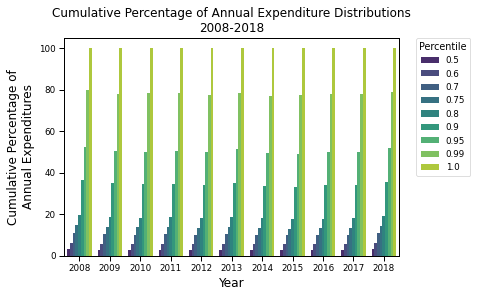

In [10]:
#plt.figure(figsize=(15,8))
ax = sns.barplot(
    x="year", 
    y="cum_pct_exp", 
    hue="quantile", 
    data=quantile_expenses_df.loc[(quantile_expenses_df["quantile"]>=.5)],
    palette="viridis"
)
plt.legend(title="Percentile", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title("\n".join(wrap(f"Cumulative Percentage of Annual Expenditure Distributions 2008-2018", 60)))
ax.set(xlabel="Year")
ax.set(ylabel="\n".join(wrap("Cumulative Percentage of Annual Expenditures", 30))) 
plt.savefig(f"concentration_curves/decade_pct_concentration.png", bbox_inches='tight')
plt.show()

In [11]:

outliers = pd.DataFrame()
for quantile in [0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99, 1]:
    df_slice = quantile_expenses_df.loc[(quantile_expenses_df["quantile"] == quantile)].copy()
    df_slice["z_score"] = np.abs(stats.zscore(df_slice["total_exp"]))

    outliers = pd.concat([outliers, df_slice.loc[(df_slice["z_score"]>2.5)]])

display(outliers)

,year,quantile,cum_pct_exp,total_exp,z_score
4,2018,0.50,3.168907,62.699033,2.740603
5,2018,0.60,6.004505,118.803327,2.784129
6,2018,0.70,10.814212,213.966743,2.792818
7,2018,0.75,14.411440,285.140405,2.776289
8,2018,0.80,19.258901,381.050805,2.757720
9,2018,0.90,35.723957,706.823441,2.652515
10,2018,0.95,51.680759,1022.539924,2.538339


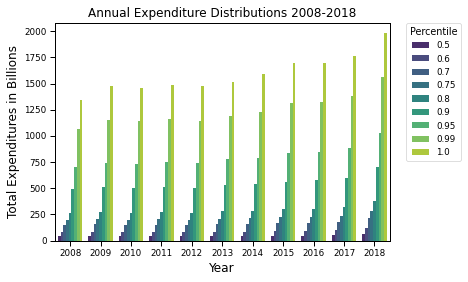

In [12]:
#plt.figure(figsize=(15,8))
ax = sns.barplot(
    x="year", 
    y="total_exp", 
    hue="quantile", 
    data=quantile_expenses_df.loc[(quantile_expenses_df["quantile"]>=.5)],
    palette="viridis"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.legend(title="Percentile", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title("\n".join(wrap(f"Annual Expenditure Distributions 2008-2018", 60)))
ax.set(xlabel="Year")
ax.set(ylabel="\n".join(wrap("Total Expenditures in Billions", 40))) 
plt.savefig(f"concentration_curves/decade_amt_concentration.png", bbox_inches='tight')
plt.show()